This tutorial and the assets can be downloaded as part of the [Wallaroo Tutorials repository](https://github.com/WallarooLabs/Wallaroo_Tutorials/blob/main/pipeline-edge-publish/edge-observability-assays).

## Wallaroo Edge Observability with Assays Tutorial

This notebook is designed to demonstrate the Wallaroo Edge Observability with Wallaroo Assays.  This notebook will walk through the process of:

* Setting up a workspace, pipeline, and model for deriving the price of a house based on inputs.
* Creating an assay from a sample of inferences.
* Display the inference result and upload the assay to the Wallaroo instance where it can be referenced later.
* Deploying the Wallaroo pipeline as a Wallaroo Server deployed on an edge device.
* Adding the edge device location to the pipeline's publish.
* Updating the assay to use the edge location's inferences for assays.

This tutorial provides the following:

* Models:
  * `models/rf_model.onnx`: The champion model that has been used in this environment for some time.
  * `models/xgb_model.onnx` and `models/gbr_model.onnx`: Rival models that will be tested against the champion.
* Data:
  * `data/xtest-1.df.json` and `data/xtest-1k.df.json`:  DataFrame JSON inference inputs with 1 input and 1,000 inputs.
  * `data/xtest-1k.arrow`:  Apache Arrow inference inputs with 1 input and 1,000 inputs.

## Prerequisites

* A deployed Wallaroo instance
* The following Python libraries installed:
  * [`wallaroo`](https://pypi.org/project/wallaroo/): The Wallaroo SDK. Included with the Wallaroo JupyterHub service by default.
  * [`pandas`](https://pypi.org/project/pandas/): Pandas, mainly used for Pandas DataFrame

## Initial Steps

### Import libraries

The first step is to import the libraries needed for this notebook.

In [1]:
import wallaroo
from wallaroo.object import EntityNotFoundError
from wallaroo.framework import Framework

from IPython.display import display

# used to display DataFrame information without truncating
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', None)

import datetime
import time



In [2]:
# used for unique connection names

import string
import random

edge_suffix= ''.join(random.choice(string.ascii_lowercase) for i in range(4))
suffix=''

# used to make a unique workspace
suffix='houseprice-demo'

workspace_name = f'edge-observability-{suffix}'
main_pipeline_name = f'houseprice-estimation'
model_name_control = f'housepricesagacontrol'
model_file_name_control = './models/rf_model.onnx'

# Set the name of the assay
edge_name=f"house-price-edge-{edge_suffix}"

In [3]:
def get_workspace(name):
    workspace = None
    for ws in wl.list_workspaces():
        if ws.name() == name:
            workspace= ws
    if(workspace == None):
        workspace = wl.create_workspace(name)
    return workspace

def get_pipeline(name, workspace):
    pipelines = workspace.pipelines()
    pipe_filter = filter(lambda x: x.name() == name, pipelines)
    pipes = list(pipe_filter)
    # we can't have a pipe in the workspace with the same name, so it's always the first
    if pipes:
        pipeline = pipes[0]
    else:
        pipeline = wl.build_pipeline(name)
    return pipeline

### Connect to the Wallaroo Instance

The first step is to connect to Wallaroo through the Wallaroo client.  The Python library is included in the Wallaroo install and available through the Jupyter Hub interface provided with your Wallaroo environment.

This is accomplished using the `wallaroo.Client()` command, which provides a URL to grant the SDK permission to your specific Wallaroo environment.  When displayed, enter the URL into a browser and confirm permissions.  Store the connection into a variable that can be referenced later.

If logging into the Wallaroo instance through the internal JupyterHub service, use `wl = wallaroo.Client()`.  For more information on Wallaroo Client settings, see the [Client Connection guide](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-client/).

In [4]:
# Login through local Wallaroo instance

wl = wallaroo.Client()

wallarooPrefix = "doc-test."
wallarooSuffix = "wallaroocommunity.ninja"

wl = wallaroo.Client(api_endpoint=f"https://{wallarooPrefix}api.{wallarooSuffix}", 
                    auth_endpoint=f"https://{wallarooPrefix}keycloak.{wallarooSuffix}", 
                    auth_type="sso")

### Create Workspace

We will create a workspace to manage our pipeline and models.  The following variables will set the name of our sample workspace then set it as the current workspace.

Workspace, pipeline, and model names should be unique to each user, so we'll add in a randomly generated suffix so multiple people can run this tutorial in a Wallaroo instance without effecting each other.

* References
  * [Wallaroo SDK Essentials Guide: Workspace Management](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-workspace/)

In [5]:
workspace = get_workspace(workspace_name)

wl.set_current_workspace(workspace)

{'name': 'edge-observability-houseprice-demo', 'id': 13, 'archived': False, 'created_by': 'd235558f-f5e6-4651-9c54-161607177dad', 'created_at': '2023-12-05T19:43:39.240681+00:00', 'models': [], 'pipelines': []}

### Upload The Champion Model

For our example, we will upload the champion model that has been trained to derive house prices from a variety of inputs.  The model file is `rf_model.onnx`, and is uploaded with the name `housingcontrol`.

* References
  * [Wallaroo SDK Essentials Guide: Model Uploads and Registrations](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-model-uploads/)

In [6]:
housing_model_control = (wl.upload_model(model_name_control, 
                                        model_file_name_control, 
                                        framework=Framework.ONNX)
                                        .configure(tensor_fields=["tensor"])
                        )

## Standard Pipeline Steps

### Build the Pipeline

This pipeline is made to be an example of an existing situation where a model is deployed and being used for inferences in a production environment.  We'll call it `housepricepipeline`, set `housingcontrol` as a pipeline step, then run a few sample inferences.

This pipeline will be a simple one - just a single pipeline step.

* References
  * [Wallaroo SDK Essentials Guide: Pipeline Management](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline/)

In [7]:
mainpipeline = get_pipeline(main_pipeline_name, workspace)

In [8]:
mainpipeline = get_pipeline(main_pipeline_name, workspace)
mainpipeline.clear()

mainpipeline.add_model_step(housing_model_control)

#minimum deployment config
deploy_config = wallaroo.DeploymentConfigBuilder().replica_count(1).cpus(0.5).memory("1Gi").build()

mainpipeline.deploy(deployment_config = deploy_config)

name,houseprice-estimation
created,2023-12-05 19:43:42.648290+00:00
last_updated,2023-12-05 19:43:43.896459+00:00
deployed,True
arch,None
tags,
versions,"3c4ac3e2-3daf-400b-97b2-b411adf6804e, e0de3f25-3e73-400f-bf64-e193e5a80d61"
steps,housepricesagacontrol
published,False


### Testing

We'll use two inferences as a quick sample test - one that has a house that should be determined around `$700k`, the other with a house determined to be around `$1.5` million.  We'll also save the start and end periods for these events to for later log functionality.

In [9]:
normal_input = pd.DataFrame.from_records({"tensor": [[4.0, 2.5, 2900.0, 5505.0, 2.0, 0.0, 0.0, 3.0, 8.0, 2900.0, 0.0, 47.6063, -122.02, 2970.0, 5251.0, 12.0, 0.0, 0.0]]})
result = mainpipeline.infer(normal_input)
display(result)

,time,in.tensor,out.variable,check_failures
0,2023-12-05 19:44:00.973,"[4.0, 2.5, 2900.0, 5505.0, 2.0, 0.0, 0.0, 3.0, 8.0, 2900.0, 0.0, 47.6063, -122.02, 2970.0, 5251.0, 12.0, 0.0, 0.0]",[718013.7],0


In [10]:
large_house_input = pd.DataFrame.from_records({'tensor': [[4.0, 3.0, 3710.0, 20000.0, 2.0, 0.0, 2.0, 5.0, 10.0, 2760.0, 950.0, 47.6696, -122.261, 3970.0, 20000.0, 79.0, 0.0, 0.0]]})
large_house_result = mainpipeline.infer(large_house_input)
display(large_house_result)

,time,in.tensor,out.variable,check_failures
0,2023-12-05 19:44:01.368,"[4.0, 3.0, 3710.0, 20000.0, 2.0, 0.0, 2.0, 5.0, 10.0, 2760.0, 950.0, 47.6696, -122.261, 3970.0, 20000.0, 79.0, 0.0, 0.0]",[1514079.4],0


## Assays

Wallaroo assays provide a method for detecting input or model drift.  These can be triggered either when unexpected input is provided for the inference, or when the model needs to be retrained from changing environment conditions.

Wallaroo assays can track either an input field and its index, or an output field and its index.  For full details, see the [Wallaroo Assays Management Guide](https://docs.wallaroo.ai/wallaroo-operations-guide/wallaroo-pipeline-management/wallaroo-pipeline-assays/).

For this example, we will:

* Perform sample inferences based on lower priced houses.
* Create an assay with the baseline set off those lower priced houses.
* Generate inferences spread across all house values, plus specific set of high priced houses to trigger the assay alert.
* Run an interactive assay to show the detection of values outside the established baseline.

### Assay Generation

To start the demonstration, we'll create a baseline of values from houses with small estimated prices and set that as our baseline. Assays are typically run on a 24 hours interval based on a 24 hour window of data, but we'll bypass that by setting our baseline time even shorter.

* References
  * [Wallaroo SDK Essentials Guide: Assays Management](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-assays/)

In [11]:
small_houses_inputs = pd.read_json('./data/smallinputs.df.json')
baseline_size = 500

# Where the baseline data will start
assay_baseline_start = datetime.datetime.now()

# These inputs will be random samples of small priced houses.
small_houses = small_houses_inputs.sample(baseline_size, replace=True).reset_index(drop=True)

# Wait 30 seconds to set this data apart from the rest
time.sleep(30)
small_results = mainpipeline.infer(small_houses)

# Set the baseline end

assay_baseline_end = datetime.datetime.now()

In [12]:
display(small_results)

,time,in.tensor,out.variable,check_failures
0,2023-12-05 19:44:32.223,"[3.0, 1.75, 1530.0, 7245.0, 1.0, 0.0, 0.0, 4.0, 7.0, 1530.0, 0.0, 47.7309989929, -122.1910018921, 1530.0, 7490.0, 31.0, 0.0, 0.0]",[431929.2],0
1,2023-12-05 19:44:32.223,"[5.0, 2.5, 2380.0, 8204.0, 1.0, 0.0, 0.0, 3.0, 8.0, 1540.0, 840.0, 47.7000007629, -122.2870025635, 2270.0, 8204.0, 58.0, 0.0, 0.0]",[712309.9],0
2,2023-12-05 19:44:32.223,"[2.0, 2.25, 1660.0, 2128.0, 2.0, 0.0, 0.0, 4.0, 8.0, 1660.0, 0.0, 47.7527999878, -122.2519989014, 1640.0, 2128.0, 41.0, 0.0, 0.0]",[437177.97],0
3,2023-12-05 19:44:32.223,"[1.0, 2.0, 3000.0, 204732.0, 2.5, 0.0, 2.0, 3.0, 8.0, 3000.0, 0.0, 47.6330986023, -121.9449996948, 2330.0, 213008.0, 35.0, 0.0, 0.0]",[716558.56],0
4,2023-12-05 19:44:32.223,"[3.0, 1.75, 1390.0, 13200.0, 2.0, 0.0, 0.0, 3.0, 7.0, 1390.0, 0.0, 47.4429016113, -121.7710037231, 1430.0, 10725.0, 35.0, 0.0, 0.0]",[252539.6],0
...,...,...,...,...
495,2023-12-05 19:44:32.223,"[2.0, 1.0, 900.0, 5000.0, 1.0, 0.0, 0.0, 3.0, 7.0, 900.0, 0.0, 47.6883010864, -122.3949966431, 1280.0, 5000.0, 70.0, 0.0, 0.0]",[448627.8],0
496,2023-12-05 19:44:32.223,"[4.0, 2.5, 3450.0, 35100.0, 2.0, 0.0, 0.0, 3.0, 10.0, 3450.0, 0.0, 47.7302017212, -122.1060028076, 3110.0, 35894.0, 27.0, 0.0, 0.0]",[921695.4],0
497,2023-12-05 19:44:32.223,"[5.0, 3.5, 4200.0, 5400.0, 2.0, 0.0, 0.0, 3.0, 9.0, 3140.0, 1060.0, 47.707698822, -122.1200027466, 3300.0, 5564.0, 2.0, 0.0, 0.0]",[1052897.9],0
498,2023-12-05 19:44:32.223,"[3.0, 2.5, 2860.0, 4500.0, 2.0, 0.0, 2.0, 3.0, 8.0, 1980.0, 880.0, 47.6463012695, -122.3710021973, 2310.0, 4500.0, 99.0, 0.0, 0.0]",[721518.44],0


In [13]:
# get the numpy values

# set the results to a non-array value
small_results_baseline_df = small_results.copy()
small_results_baseline_df['variable']=small_results['out.variable'].map(lambda x: x[0])
small_results_baseline_df

,time,in.tensor,out.variable,check_failures,variable
0,2023-12-05 19:44:32.223,"[3.0, 1.75, 1530.0, 7245.0, 1.0, 0.0, 0.0, 4.0, 7.0, 1530.0, 0.0, 47.7309989929, -122.1910018921, 1530.0, 7490.0, 31.0, 0.0, 0.0]",[431929.2],0,431929.20
1,2023-12-05 19:44:32.223,"[5.0, 2.5, 2380.0, 8204.0, 1.0, 0.0, 0.0, 3.0, 8.0, 1540.0, 840.0, 47.7000007629, -122.2870025635, 2270.0, 8204.0, 58.0, 0.0, 0.0]",[712309.9],0,712309.90
2,2023-12-05 19:44:32.223,"[2.0, 2.25, 1660.0, 2128.0, 2.0, 0.0, 0.0, 4.0, 8.0, 1660.0, 0.0, 47.7527999878, -122.2519989014, 1640.0, 2128.0, 41.0, 0.0, 0.0]",[437177.97],0,437177.97
3,2023-12-05 19:44:32.223,"[1.0, 2.0, 3000.0, 204732.0, 2.5, 0.0, 2.0, 3.0, 8.0, 3000.0, 0.0, 47.6330986023, -121.9449996948, 2330.0, 213008.0, 35.0, 0.0, 0.0]",[716558.56],0,716558.56
4,2023-12-05 19:44:32.223,"[3.0, 1.75, 1390.0, 13200.0, 2.0, 0.0, 0.0, 3.0, 7.0, 1390.0, 0.0, 47.4429016113, -121.7710037231, 1430.0, 10725.0, 35.0, 0.0, 0.0]",[252539.6],0,252539.60
...,...,...,...,...,...
495,2023-12-05 19:44:32.223,"[2.0, 1.0, 900.0, 5000.0, 1.0, 0.0, 0.0, 3.0, 7.0, 900.0, 0.0, 47.6883010864, -122.3949966431, 1280.0, 5000.0, 70.0, 0.0, 0.0]",[448627.8],0,448627.80
496,2023-12-05 19:44:32.223,"[4.0, 2.5, 3450.0, 35100.0, 2.0, 0.0, 0.0, 3.0, 10.0, 3450.0, 0.0, 47.7302017212, -122.1060028076, 3110.0, 35894.0, 27.0, 0.0, 0.0]",[921695.4],0,921695.40
497,2023-12-05 19:44:32.223,"[5.0, 3.5, 4200.0, 5400.0, 2.0, 0.0, 0.0, 3.0, 9.0, 3140.0, 1060.0, 47.707698822, -122.1200027466, 3300.0, 5564.0, 2.0, 0.0, 0.0]",[1052897.9],0,1052897.90
498,2023-12-05 19:44:32.223,"[3.0, 2.5, 2860.0, 4500.0, 2.0, 0.0, 2.0, 3.0, 8.0, 1980.0, 880.0, 47.6463012695, -122.3710021973, 2310.0, 4500.0, 99.0, 0.0, 0.0]",[721518.44],0,721518.44


In [37]:
logs = mainpipeline.logs(dataset=['time', 'out.variable', 'metadata'])
display(logs.loc[:, ['time', 'metadata.partition']])
display(logs[logs['metadata.partition'] == 'engine-867645f7d7-hm565'])

,time,metadata.partition
0,2023-12-05 19:44:32.223,engine-867645f7d7-hm565
1,2023-12-05 19:44:32.223,engine-867645f7d7-hm565
2,2023-12-05 19:44:32.223,engine-867645f7d7-hm565
3,2023-12-05 19:44:32.223,engine-867645f7d7-hm565
4,2023-12-05 19:44:32.223,engine-867645f7d7-hm565
...,...,...
95,2023-12-05 19:44:32.223,engine-867645f7d7-hm565
96,2023-12-05 19:44:32.223,engine-867645f7d7-hm565
97,2023-12-05 19:44:32.223,engine-867645f7d7-hm565
98,2023-12-05 19:44:32.223,engine-867645f7d7-hm565


,time,out.variable,metadata.last_model,metadata.pipeline_version,metadata.elapsed,metadata.dropped,metadata.partition
0,2023-12-05 19:44:32.223,[544392.06],"{""model_name"":""housepricesagacontrol"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}",3c4ac3e2-3daf-400b-97b2-b411adf6804e,"[1676522, 2239629]",[],engine-867645f7d7-hm565
1,2023-12-05 19:44:32.223,[721518.44],"{""model_name"":""housepricesagacontrol"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}",3c4ac3e2-3daf-400b-97b2-b411adf6804e,"[1676522, 2239629]",[],engine-867645f7d7-hm565
2,2023-12-05 19:44:32.223,[1052897.9],"{""model_name"":""housepricesagacontrol"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}",3c4ac3e2-3daf-400b-97b2-b411adf6804e,"[1676522, 2239629]",[],engine-867645f7d7-hm565
3,2023-12-05 19:44:32.223,[921695.4],"{""model_name"":""housepricesagacontrol"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}",3c4ac3e2-3daf-400b-97b2-b411adf6804e,"[1676522, 2239629]",[],engine-867645f7d7-hm565
4,2023-12-05 19:44:32.223,[448627.8],"{""model_name"":""housepricesagacontrol"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}",3c4ac3e2-3daf-400b-97b2-b411adf6804e,"[1676522, 2239629]",[],engine-867645f7d7-hm565
...,...,...,...,...,...,...,...
95,2023-12-05 19:44:32.223,[290987.34],"{""model_name"":""housepricesagacontrol"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}",3c4ac3e2-3daf-400b-97b2-b411adf6804e,"[1676522, 2239629]",[],engine-867645f7d7-hm565
96,2023-12-05 19:44:32.223,[291903.97],"{""model_name"":""housepricesagacontrol"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}",3c4ac3e2-3daf-400b-97b2-b411adf6804e,"[1676522, 2239629]",[],engine-867645f7d7-hm565
97,2023-12-05 19:44:32.223,[350049.3],"{""model_name"":""housepricesagacontrol"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}",3c4ac3e2-3daf-400b-97b2-b411adf6804e,"[1676522, 2239629]",[],engine-867645f7d7-hm565
98,2023-12-05 19:44:32.223,[294203.53],"{""model_name"":""housepricesagacontrol"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}",3c4ac3e2-3daf-400b-97b2-b411adf6804e,"[1676522, 2239629]",[],engine-867645f7d7-hm565


In [36]:
# display(logs.loc[logs['metadata.partition'].filter(regex='engine.*')])
display(logs.filter(regex='engine.*'))

Series([], Name: metadata.partition, dtype: object)

In [26]:
print(mainpipeline)

{'name': 'houseprice-estimation', 'create_time': datetime.datetime(2023, 12, 5, 19, 43, 42, 648290, tzinfo=tzutc()), 'definition': "[{'ModelInference': {'models': [{'name': 'housepricesagacontrol', 'version': 'e8cc1034-fd24-46b8-9f2c-59be397f7d1f', 'sha': 'e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6'}]}}]"}


In [14]:
# get the numpy values
small_results_baseline = small_results_baseline_df['variable'].to_numpy()
small_results_baseline

array([ 431929.2 ,  712309.9 ,  437177.97,  716558.56,  252539.6 ,
       1295531.8 ,  524275.4 ,  467743.03,  519346.94,  437177.97,
        444885.6 ,  246901.14,  253679.63,  713485.7 ,  450996.34,
        341649.34,  400561.2 ,  458858.44,  424966.6 ,  736751.3 ,
        437177.97,  657905.75,  581002.94,  424966.6 ,  422481.5 ,
        481600.13,  403520.16,  423382.72,  630865.5 ,  453195.8 ,
        811666.7 ,  563844.44,  464057.38,  424966.6 ,  559631.06,
        388243.13,  242591.38,  340764.53,  595497.3 ,  323856.28,
        349668.4 ,  359614.66, 1160512.8 ,  293808.03,  380009.28,
        437177.97,  256845.58,  782434.44,  557391.25,  448627.8 ,
        260603.88,  450867.7 ,  274207.16,  480151.44,  354512.44,
        712309.9 ,  381737.6 ,  381737.6 ,  873848.44,  252192.9 ,
        258321.66,  469038.13,  683845.75,  529302.44,  784103.56,
        421402.1 ,  292859.44,  451058.3 ,  435628.72,  246088.6 ,
        368504.3 ,  236238.67,  411000.13,  657905.75,  291903

In [15]:
assay_baseline_from_numpy_name = "edge assays from numpy"

# assay builder by baseline
assay_builder_from_numpy = wl.build_assay(assay_name=assay_baseline_from_numpy_name, 
                               pipeline=mainpipeline, 
                               model_name=model_name_control, 
                               iopath="output variable 0", 
                               baseline_data=small_results_baseline)

# for brand new instances, this provides time for the pipeline logs to finish writing
time.sleep(60)

In [20]:
# set the width
assay_builder_from_numpy.window_builder().add_width(minutes=1).add_interval(minutes=1)

In [21]:
assay_config_from_numpy = assay_builder_from_numpy.build()

In [22]:
assay_analysis_from_numpy = assay_config_from_numpy.interactive_run()

Exception: Failed to parse response from model insights: error decoding response body: invalid type: map, expected a sequence at line 1 column 0

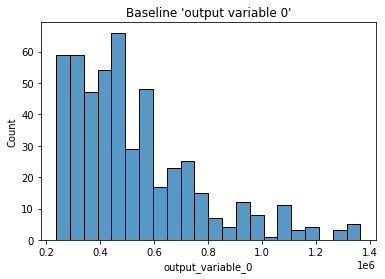

In [ ]:
# get the histogram from the numpy baseline
assay_builder_from_numpy.baseline_histogram()

### Assay Testing

Now we'll perform some inferences with a spread of values, then a larger set with a set of larger house values to trigger our assay alert.  We'll use our assay created from the numpy baseline values to demonstrate.

Because our assay windows are 1 minutes, we'll need to stagger our inference values to be set into the proper windows.  This will take about 4 minutes.

In [ ]:
# Get a spread of house values

time.sleep(35)
# regular_houses_inputs = pd.read_json('./data/xtest-1k.df.json', orient="records")
inference_size = 1000

# regular_houses = regular_houses_inputs.sample(inference_size, replace=True).reset_index(drop=True)

# And a spread of large house values

big_houses_inputs = pd.read_json('./data/biginputs.df.json', orient="records")
big_houses = big_houses_inputs.sample(inference_size, replace=True).reset_index(drop=True)

# Set the start for our assay window period.
assay_window_start = datetime.datetime.now()

mainpipeline.infer(big_houses)


# End our assay window period
time.sleep(10)
assay_window_end = datetime.datetime.now()

In [ ]:
assay_builder_from_numpy.add_run_until(assay_window_end)
assay_builder_from_numpy.window_builder().add_width(minutes=1).add_interval(minutes=1)
assay_config_from_dates = assay_builder_from_numpy.build()
assay_analysis_from_numpy = assay_config_from_numpy.interactive_run()

Generated 1 analyses


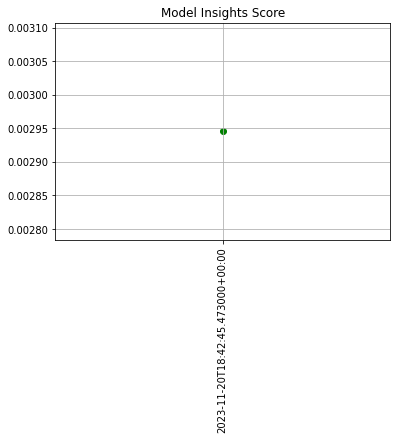

In [ ]:
# Show how many assay windows were analyzed, then show the chart
print(f"Generated {len(assay_analysis_from_numpy)} analyses")
assay_analysis_from_numpy.chart_scores()

In [ ]:
# Display the results as a DataFrame - we're mainly interested in the score and whether the 
# alert threshold was triggered
display(assay_analysis_from_numpy.to_dataframe().loc[:, ["score", "start", "alert_threshold", "status"]])

,score,start,alert_threshold,status
0,0.002945,2023-11-20T18:42:45.473000+00:00,0.25,Ok


## Edge Deployment

We can now deploy the pipeline to an edge device.  This will require the following steps:

* Publish the pipeline:  Publishes the pipeline to the OCI registry.
* Add Edge:  Add the edge location to the pipeline publish.
* Deploy Edge:  Deploy the edge device with the edge location settings.

### Publish Pipeline

Publishing the pipeline uses the pipeline `publish()` command, which returns the OCI registry information.

In [ ]:
assay_pub = mainpipeline.publish()

Waiting for pipeline publish... It may take up to 600 sec.
Pipeline is Publishing...Published.


### Add Edge

The edge location is added with the `publish.add_edge(name)` method.  This returns the OCI registration information, and the `EDGE_BUNDLE` information.  The `EDGE_BUNDLE` data is a base64 encoded set of parameters for the pipeline that the edge device is associated with.

In [ ]:
display(edge_name)
edge_publish = assay_pub.add_edge(edge_name)
display(edge_publish)

'house-price-edge-ysyf'

ID,4
Pipeline Version,1de7790e-937a-4b8d-85af-746a98ca6ad7
Status,Published
Engine URL,ghcr.io/wallaroolabs/doc-samples/engines/proxy/wallaroo/ghcr.io/wallaroolabs/standalone-mini:v2023.4.0-4103
Pipeline URL,ghcr.io/wallaroolabs/doc-samples/pipelines/houseprice-estimation:1de7790e-937a-4b8d-85af-746a98ca6ad7
Helm Chart URL,oci://ghcr.io/wallaroolabs/doc-samples/charts/houseprice-estimation
Helm Chart Reference,ghcr.io/wallaroolabs/doc-samples/charts@sha256:eeacd9bb94d2c711a79061f6d93c48d1a52660aeaa456721df1bc2622dd72bf1
Helm Chart Version,0.0.1-1de7790e-937a-4b8d-85af-746a98ca6ad7
Engine Config,"{'engine': {'resources': {'limits': {'cpu': 4.0, 'memory': '3Gi'}, 'requests': {'cpu': 4.0, 'memory': '3Gi'}}}, 'engineAux': {}, 'enginelb': {'resources': {'limits': {'cpu': 1.0, 'memory': '512Mi'}, 'requests': {'cpu': 0.2, 'memory': '512Mi'}}}}"
User Images,[]
Created By,john.hummel@wallaroo.ai


### DevOps Deployment

The edge deployment is performed with `docker run`, `docker compose`, or `helm` installations.  The following command generates the `docker run` command, with the following values provided by the DevOps Engineer:

* `$REGISTRYURL`
* `$REGISTRYUSERNAME`
* `$REGISTRYPASSWORD`

Before deploying, create the `./data` directory that is used to store the authentication credentials.

In [28]:
# create docker run 

docker_command = f'''
mkdir ./data
docker run -p 8080:8080 \\
    -v ./data:/persist \\
    -e DEBUG=true \\
    -e OCI_REGISTRY=$REGISTRYURL \\
    -e EDGE_BUNDLE={edge_publish.docker_run_variables['EDGE_BUNDLE']} \\
    -e CONFIG_CPUS=1 \\
    -e OCI_USERNAME=$REGISTRYUSERNAME \\
    -e OCI_PASSWORD=$REGISTRYPASSWORD \\
    -e PIPELINE_URL={edge_publish.pipeline_url} \\
    {edge_publish.engine_url}
'''

print(docker_command)


mkdir ./data
docker run -p 8080:8080 \
    -v ./data:/persist \
    -e DEBUG=true \
    -e OCI_REGISTRY=$REGISTRYURL \
    -e EDGE_BUNDLE=ZXhwb3J0IEJVTkRMRV9WRVJTSU9OPTEKZXhwb3J0IEVER0VfTkFNRT1ob3VzZS1wcmljZS1lZGdlLXlzeWYKZXhwb3J0IEpPSU5fVE9LRU49MTNmMWZkMDQtMWM0Yi00Zjc0LTk2ZDYtNWE2YTFjNDZlNjNlCmV4cG9ydCBPUFNDRU5URVJfSE9TVD1kb2MtdGVzdC5lZGdlLndhbGxhcm9vY29tbXVuaXR5Lm5pbmphCmV4cG9ydCBQSVBFTElORV9VUkw9Z2hjci5pby93YWxsYXJvb2xhYnMvZG9jLXNhbXBsZXMvcGlwZWxpbmVzL2hvdXNlcHJpY2UtZXN0aW1hdGlvbjoxZGU3NzkwZS05MzdhLTRiOGQtODVhZi03NDZhOThjYTZhZDcKZXhwb3J0IFdPUktTUEFDRV9JRD03 \
    -e CONFIG_CPUS=1 \
    -e OCI_USERNAME=$REGISTRYUSERNAME \
    -e OCI_PASSWORD=$REGISTRYPASSWORD \
    -e PIPELINE_URL=ghcr.io/wallaroolabs/doc-samples/pipelines/houseprice-estimation:1de7790e-937a-4b8d-85af-746a98ca6ad7 \
    ghcr.io/wallaroolabs/doc-samples/engines/proxy/wallaroo/ghcr.io/wallaroolabs/standalone-mini:v2023.4.0-4103



```bash
curl testboy.local:8080/pipelines
{"pipelines":[{"id":"housepricesagapipeline","status":"Running"}]}
```

```bash
curl -X POST testboy.local:8080/pipelines/houseprice-estimation \
    -H "Content-Type: application/vnd.apache.arrow.file" \
    --data-binary @./data/xtest-1k.arrow 
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  513k  100  442k  100 73100  19.8M  3287k --:--:-- --:--:-- --:--:-- 23.8M
```

In [29]:
mainpipeline.export_logs(limit=50000,
    directory='partition-edge-observability',
    file_prefix='edge-logs',
    dataset=['time', 'out.variable', 'metadata'])

In [30]:
# display the partition only results

df_logs = pd.read_json('./partition-edge-observability/edge-logs-1.json', 
                       orient="records", 
                       lines=True)
#filter out just the `metadata.partition='houseprice-edgebaseline-examples'

display(df_logs[df_logs['metadata.partition']==edge_name].loc[:, ['out.variable', 'metadata.partition']])
# display(df_logs.loc[:, ['out.variable', 'metadata.partition']])

,out.variable,metadata.partition
1000,[581002.9375],house-price-edge-ysyf
1001,[706823.5],house-price-edge-ysyf
1002,[1060847.5],house-price-edge-ysyf
1003,[441960.375],house-price-edge-ysyf
1004,[827411.125],house-price-edge-ysyf
...,...,...
2495,[513264.625],house-price-edge-ysyf
2496,[758714.1875],house-price-edge-ysyf
2497,[448627.6875],house-price-edge-ysyf
2498,[615094.5625],house-price-edge-ysyf


In [31]:
all_locations = [pd.unique(df_logs['metadata.partition']).tolist()][0]
all_locations

['engine-7ccc6d55fc-fvj95', 'house-price-edge-ysyf']

In [32]:
assay_baseline_from_edge_name = "edge assays from edge"

# assay builder by baseline
assay_builder_from_edge = wl.build_assay(assay_name=assay_baseline_from_edge_name, 
                               pipeline=mainpipeline, 
                               model_name=model_name_control, 
                               iopath="output variable 0", 
                               baseline_data=small_results_baseline)

# for brand new instances, this provides time for the pipeline logs to finish writing
time.sleep(60)

location_window_end = datetime.datetime.now()

In [33]:
assay_builder_from_edge.add_run_until(location_window_end)
assay_builder_from_edge.window_builder().add_location_filter([edge_name])
assay_builder_from_edge.window_builder().add_width(minutes=1).add_interval(minutes=1)
assay_config_from_edge = assay_builder_from_edge.build()
assay_analysis_from_edge = assay_config_from_edge.interactive_run()

Generated 1 analyses


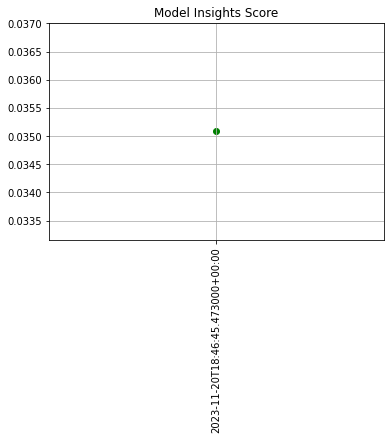

In [34]:
# Show how many assay windows were analyzed, then show the chart
print(f"Generated {len(assay_analysis_from_edge)} analyses")
assay_analysis_from_edge.chart_scores()

In [35]:
# Display the results as a DataFrame - we're mainly interested in the score and whether the 
# alert threshold was triggered
display(assay_analysis_from_edge.to_dataframe().loc[:, ["score", "start", "alert_threshold", "status"]])

,score,start,alert_threshold,status
0,0.035084,2023-11-20T18:46:45.473000+00:00,0.25,Ok


In [36]:
assay_baseline_from_edge_name = "edge assays all locations"

# assay builder by baseline
assay_builder_from_all_locations = wl.build_assay(assay_name=assay_baseline_from_edge_name, 
                               pipeline=mainpipeline, 
                               model_name=model_name_control, 
                               iopath="output variable 0", 
                               baseline_data=small_results_baseline)

# for brand new instances, this provides time for the pipeline logs to finish writing
time.sleep(60)

all_locations_window_end = datetime.datetime.now()

In [37]:
assay_builder_from_all_locations.add_run_until(all_locations_window_end)
assay_builder_from_all_locations.window_builder().add_location_filter(all_locations)
assay_builder_from_all_locations.window_builder().add_width(minutes=1).add_interval(minutes=1)
assay_config_all_locations_from_dates = assay_builder_from_all_locations.build()
assay_analysis_from_all_locations = assay_config_all_locations_from_dates.interactive_run()

Generated 3 analyses


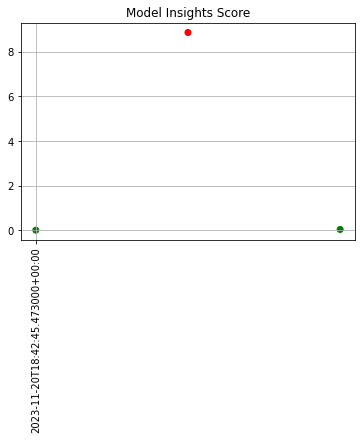

In [38]:
# Show how many assay windows were analyzed, then show the chart
print(f"Generated {len(assay_analysis_from_all_locations)} analyses")
assay_analysis_from_all_locations.chart_scores()

### Undeploy Main Pipeline

With the examples and tutorial complete, we will undeploy the main pipeline and return the resources back to the Wallaroo instance.

In [39]:
mainpipeline.undeploy()

Waiting for undeployment - this will take up to 45s ..................................... ok


name,houseprice-estimation
created,2023-11-20 18:42:35.686701+00:00
last_updated,2023-11-20 18:45:01.284289+00:00
deployed,False
arch,None
tags,
versions,"1de7790e-937a-4b8d-85af-746a98ca6ad7, 2cf51c49-c009-4827-9054-bde836cb271c, 96b5ce06-582d-4c2c-b330-6c1d45eabba4"
steps,housepricesagacontrol
published,False
